In [1]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch

In [61]:
import os
import re
from PIL import Image
from torch.utils.data import Dataset


class SkyDataset(Dataset):
    def __init__(self, root_data_folder="/projects/SkyGAN/clouds_fisheye", desc_file="processed_1K_JPGs.txt", transform=None, seq_len=2):
        self._root_data_folder = root_data_folder
        self._desc_file = desc_file
        
        image_path_list = self._get_image_paths()
        image_path_dict = self._image_paths_to_dict(image_path_list)
        image_seq_splitted_dict = self._split_lists(image_path_dict)
        image_seq_splitted_list = self._get_lists(image_seq_splitted_dict)
        self._image_path_list = self._seq_to_pairs(image_seq_splitted_list, seq_len)

        
        self._n_samples = len(self._image_path_list)
        
        self._transform = transform

    def _extract_number(self, file_name):
        match = re.search(r'_(\d+)\.', file_name)
        if match:
            return int(match.group(1))
        return 0

    def _get_image_paths(self):
        file_path = os.path.join(self._root_data_folder, self._desc_file)
        try:
            with open(file_path) as f:
                paths = f.read().strip().split('\n')
                paths = list(map(lambda x: os.path.join(self._root_data_folder, x), paths))
            return paths
        except FileNotFoundError:
            raise FileNotFoundError(f"Could not find file {self._desc_file} enumerating all image paths")
        except IOError:
            raise IOError(f"An IOError occured while reading file {file_path}. Check correctness of the contents")

    def _image_paths_to_dict(self, paths):
        locations_map = {}
        for path in paths:
            full_path, file = os.path.split(path)
            if full_path in locations_map:
                locations_map[full_path].append(file)
            else:
                locations_map[full_path] = [file]
                
        for path in locations_map:
            locations_map[path] = sorted(locations_map[path], key=self._extract_number)
            
        return locations_map

    def _get_most_common_offset(self, filenames):
        offsets = {}
        for i in range(len(filenames) - 1):
            current = self._extract_number(filenames[i])
            next = self._extract_number(filenames[i + 1])
            if (next - current) in offsets:
                offsets[(next - current)] += 1
            else:
                offsets[(next - current)] = 1
    
        max_offset = max(offsets, key = lambda x: offsets[x])
        return max_offset

    def _split_lists(self, locations_map):
        res_dict = {}
        for path in locations_map:
            offset = self._get_most_common_offset(locations_map[path])
            
            prev_number = self._extract_number(locations_map[path][0])
            main_list = []
            temp_list = [locations_map[path][0]]
            
            for i in range(1, len(locations_map[path])):
                order_number = self._extract_number(locations_map[path][i])
                if (order_number - prev_number) == offset:
                    temp_list.append(locations_map[path][i])
                else:
                    main_list.append(temp_list)
                    temp_list = [locations_map[path][i]]
                prev_number = order_number
            if temp_list:
                main_list.append(temp_list)
            res_dict[path] = main_list
            
        return res_dict

    def _get_lists(self, splitted_locations_map):
        res = []
        for root_path in splitted_locations_map:
            for seq in splitted_locations_map[root_path]:
                if len(seq) > 1:
                    res.append(list(map(lambda x: os.path.join(root_path, x), seq)))
        return res

    def _seq_to_pairs(self, sequential_paths, seq_len, offset=10):
        res = []
        for seq in sequential_paths:
            if len(seq) < seq_len:
                continue

            for i in range(len(seq) - (offset) * (seq_len - 1)):
                tmp = []
                for j in range(0, offset * seq_len, offset):
                    tmp.append(seq[i + j])
                res.append(tmp)
        return res

    def __getitem__(self, item):
        initial = Image.open(self._image_path_list[item][0])
        prediction = Image.open(self._image_path_list[item][1])

        if self._transform:
            initial = self._transform(initial)
            prediction = self._transform(prediction)

        return initial, prediction

    def __len__(self):
        return len(self._image_path_list)
        

In [62]:
tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [63]:
sd = SkyDataset(transform=tfms)
dataset = SkyDataset(transform=tfms)
train_dataloader = DataLoader(dataset=dataset, batch_size=16, shuffle=True)

In [64]:
from torchvision.transforms import ToPILImage
def show_tensors_as_images(batch1, batch2):
    for i in range(len(batch1)):
        pil_image1 = ToPILImage()(batch1[i])
        pil_image2 = ToPILImage()(batch2[i])
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(pil_image1)
        axes[0].axis('off')
        axes[1].imshow(pil_image2)
        axes[1].axis('off')
        plt.show()

In [65]:
imgs = next(iter(train_dataloader))

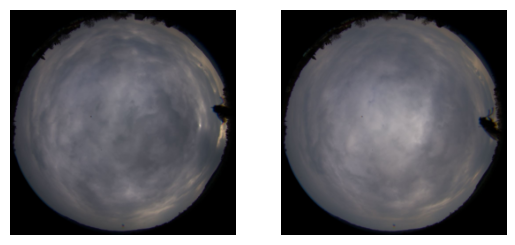

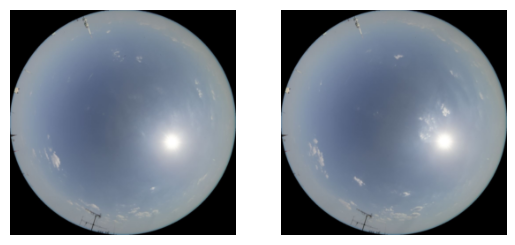

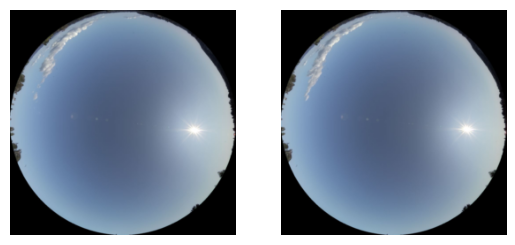

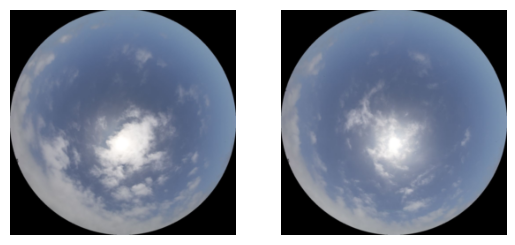

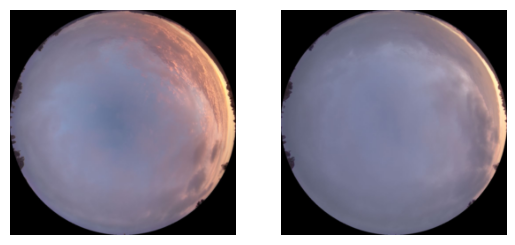

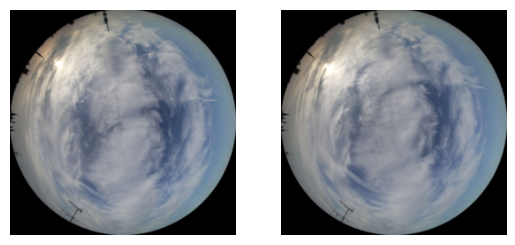

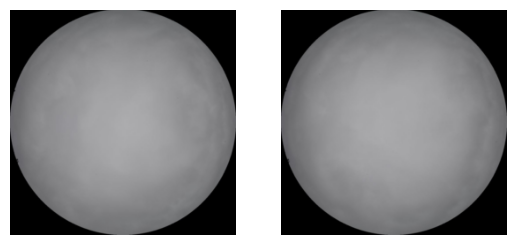

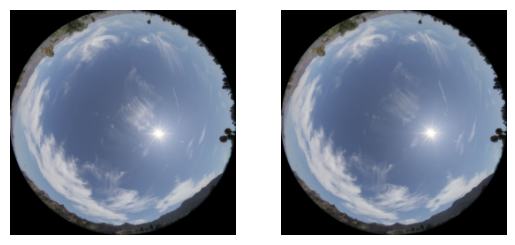

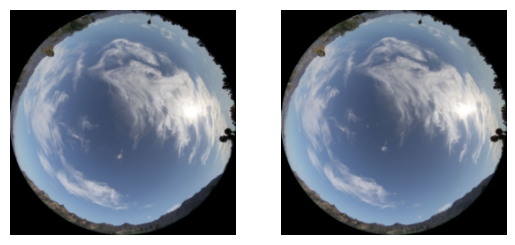

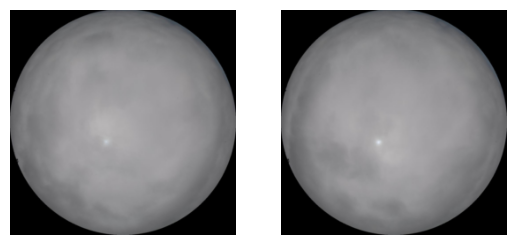

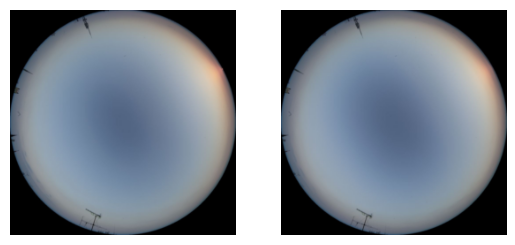

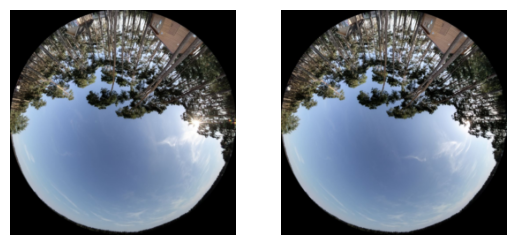

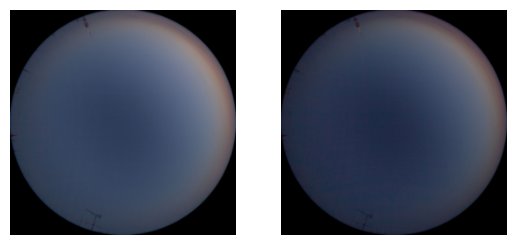

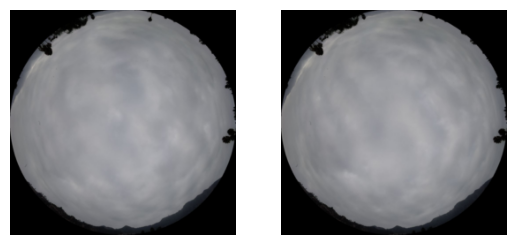

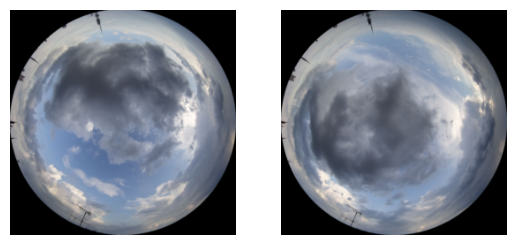

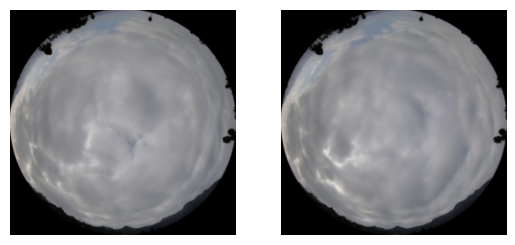

In [66]:
show_tensors_as_images(imgs[0], imgs[1])